In [137]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, LassoCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import KFold, learning_curve, cross_val_score, ShuffleSplit, train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import skew
from statsmodels.stats.outliers_influence import variance_inflation_factor
import kaggle
%matplotlib inline
sns.set_style('darkgrid')
pd.set_option('display.max_columns', 100)

In [138]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

all_data = pd.concat([df_train, df_test], ignore_index=True)
all_data['SalePrice'].fillna(0, inplace=True)
original_data = all_data.copy()
all_data.drop(['Id'], axis=1, inplace=True)

print('Train Set: {}, {}'.format(df_train.shape[0], df_train.shape[1]))
print('Test Set: {}, {}'.format(df_test.shape[0], df_test.shape[1]))
print('All Data: {}, {}'.format(all_data.shape[0], all_data.shape[1]))

submission = pd.DataFrame(columns=['Id', 'SalePrice'])
submission['Id'] = df_test['Id']
submission['SalePrice'] = 0

Train Set: 1460, 81
Test Set: 1459, 80
All Data: 2919, 80


In [139]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 80 columns):
1stFlrSF         2919 non-null int64
2ndFlrSF         2919 non-null int64
3SsnPorch        2919 non-null int64
Alley            198 non-null object
BedroomAbvGr     2919 non-null int64
BldgType         2919 non-null object
BsmtCond         2837 non-null object
BsmtExposure     2837 non-null object
BsmtFinSF1       2918 non-null float64
BsmtFinSF2       2918 non-null float64
BsmtFinType1     2840 non-null object
BsmtFinType2     2839 non-null object
BsmtFullBath     2917 non-null float64
BsmtHalfBath     2917 non-null float64
BsmtQual         2838 non-null object
BsmtUnfSF        2918 non-null float64
CentralAir       2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
Electrical       2918 non-null object
EnclosedPorch    2919 non-null int64
ExterCond        2919 non-null object
ExterQual        2919 non-null object
Exterior1st      291

In [140]:
# According to Data Description some datatypes are incorrect so lets fix them. 
# MSSubClass, OverallQual and OverallCond are, actually, categorical.
for feature in ['MSSubClass', 'OverallQual', 'OverallCond']:
    all_data[feature] = all_data[feature].astype('object')

In [141]:
all_data[all_data['SalePrice'] > 0].sample(10)

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,CentralAir,Condition1,Condition2,Electrical,EnclosedPorch,ExterCond,ExterQual,Exterior1st,Exterior2nd,Fence,FireplaceQu,Fireplaces,Foundation,FullBath,Functional,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,GrLivArea,HalfBath,Heating,HeatingQC,HouseStyle,KitchenAbvGr,KitchenQual,LandContour,LandSlope,LotArea,LotConfig,LotFrontage,LotShape,LowQualFinSF,MSSubClass,MSZoning,MasVnrArea,MasVnrType,MiscFeature,MiscVal,MoSold,Neighborhood,OpenPorchSF,OverallCond,OverallQual,PavedDrive,PoolArea,PoolQC,RoofMatl,RoofStyle,SaleCondition,SalePrice,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
48,736,716,0,NaN,2,2fmCon,TA,No,0.0,0.0,Unf,Unf,0.0,0.0,TA,736.0,Y,Norm,Norm,SBrkr,102,TA,TA,MetalSd,MetalSd,NaN,NaN,0,BrkTil,2,Typ,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1452,0,GasA,Gd,2Story,3,TA,Lvl,Gtl,4456,Inside,33.0,Reg,0,190,RM,0.0,None,NaN,0,6,OldTown,0,5,4,N,0,NaN,CompShg,Gable,Partial,113000.0,New,0,Pave,8,736.0,AllPub,0,1920,2008,2009
303,894,0,0,NaN,3,1Fam,TA,No,894.0,0.0,ALQ,Unf,1.0,0.0,TA,0.0,Y,Norm,Norm,SBrkr,0,TA,TA,VinylSd,VinylSd,GdWo,NaN,0,PConc,1,Typ,552.0,2.0,TA,Unf,TA,Attchd,1975.0,894,0,GasA,TA,1Story,1,TA,Lvl,Gtl,9800,Corner,70.0,Reg,0,20,RL,0.0,None,NaN,0,7,CollgCr,0,7,5,Y,0,NaN,CompShg,Gable,Abnorml,149900.0,WD,0,Pave,5,894.0,AllPub,256,1972,1972,2006
828,1160,966,0,NaN,3,1Fam,Gd,Gd,249.0,764.0,LwQ,ALQ,0.0,1.0,TA,0.0,Y,Norm,Norm,SBrkr,0,TA,TA,Plywood,Plywood,NaN,NaN,0,PConc,2,Min2,538.0,2.0,TA,Fin,TA,Attchd,1967.0,2126,1,GasA,TA,2Story,1,TA,Low,Sev,28698,CulDSac,NaN,IR2,0,60,RL,0.0,None,NaN,0,6,ClearCr,0,5,5,Y,0,NaN,Tar&Grv,Flat,Abnorml,185000.0,WD,225,Pave,7,1013.0,AllPub,486,1967,1967,2009
528,605,0,0,NaN,2,1Fam,TA,Mn,348.0,0.0,ALQ,Unf,1.0,0.0,TA,180.0,Y,Norm,Norm,SBrkr,144,TA,TA,Wd Sdng,Wd Sdng,NaN,NaN,0,BrkTil,1,Typ,0.0,0.0,NaN,NaN,NaN,NaN,NaN,605,0,GasA,Ex,1Story,1,TA,Lvl,Gtl,9098,Inside,58.0,IR1,0,30,RL,0.0,None,NaN,0,7,Edwards,0,7,4,N,0,NaN,CompShg,Gable,Normal,86000.0,WD,0,Pave,5,528.0,AllPub,0,1920,2002,2007
171,1656,0,0,NaN,3,1Fam,Gd,Gd,639.0,0.0,BLQ,Unf,1.0,0.0,TA,441.0,Y,Norm,Norm,SBrkr,0,TA,TA,BrkFace,Plywood,NaN,Gd,2,CBlock,1,Typ,528.0,2.0,TA,Fin,TA,Attchd,1960.0,1656,0,GasA,Fa,1Story,1,TA,Lvl,Gtl,31770,Corner,141.0,IR1,0,20,RL,112.0,Stone,NaN,0,5,NAmes,62,5,6,P,0,NaN,CompShg,Hip,Normal,215000.0,WD,0,Pave,7,1080.0,AllPub,210,1960,1960,2010
895,983,813,0,NaN,4,1Fam,TA,No,400.0,0.0,BLQ,Unf,1.0,0.0,TA,380.0,Y,Norm,Norm,SBrkr,0,TA,TA,HdBoard,HdBoard,NaN,TA,1,CBlock,1,Typ,483.0,2.0,TA,RFn,TA,Attchd,1963.0,1796,1,GasA,TA,2Story,1,TA,Lvl,Gtl,7056,Inside,71.0,Reg,0,60,RL,415.0,BrkFace,NaN,0,10,NAmes,50,5,6,Y,0,NaN,CompShg,Hip,Normal,140000.0,WD,0,Pave,8,780.0,AllPub,0,1963,1963,2008
1401,864,729,0,NaN,3,1Fam,TA,No,759.0,0.0,GLQ,Unf,1.0,0.0,TA,80.0,Y,Norm,Norm,SBrkr,0,TA,TA,VinylSd,VinylSd,NaN,TA,1,PConc,2,Typ,398.0,2.0,TA,Fin,TA,Attchd,2004.0,1593,1,GasA,Ex,2Story,1,TA,Lvl,Gtl,7415,Inside,62.0,IR1,0,60,RL,0.0,None,NaN,0,4,Gilbert,75,5,6,Y,0,NaN,CompShg,Gable,Normal,193000.0,WD,0,Pave,8,839.0,AllPub,100,2004,2004,2008
1330,1588,0,0,NaN,3,1Fam,Gd,Av,0.0,0.0,Unf,Unf,0.0,0.0,Gd,1588.0,Y,Norm,Norm,SBrkr,0,TA,Gd,VinylSd,VinylSd,NaN,Gd,1,PConc,2,Typ,825.0,3.0,TA,RFn,TA,Attchd,2006.0,1588,0,GasA,Ex,1Story,1,Gd,Lvl,Gtl,10000,Inside,85.0,Reg,0,20,RL,410.0,Stone,NaN,0,12,Somerst,45,5,8,Y,0,NaN,CompShg,Hip,Normal,227000.0,WD,0,Pave,7,1588.0,AllPub,144,2006,2006,2007
172,1064,703,0,NaN,2,TwnhsE,Gd,No,495.0,215.0,GLQ,Rec,1.0,0.0,Gd,354.0,Y,Norm,Norm,SBrkr,0,Gd,Gd,HdBoard,HdBoard,NaN,TA,1,PConc,2,Typ,504.0,2.0,TA,RFn,Gd,Attchd,1987.0,1767,0,GasA,Gd,2Story,1,Gd,Lvl,Gtl,5306,Inside,44.0,IR1,0,160,RL,0.0,None,NaN,0,6,StoneBr,35,7,7,Y,0,NaN,CompShg,Gable,Normal,239000.0,WD,0,Pave,5,1064.0,AllPub,441,1987,1987,2006
1049,930,0,0,NaN,2,1Fam,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,Y,Norm,Nor

In [142]:
all_data[all_data['SalePrice'] > 0].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
1stFlrSF,1460.0,1162.626712,386.587738,334.0,882.00,1087.0,1391.25,4692.0
2ndFlrSF,1460.0,346.992466,436.528436,0.0,0.00,0.0,728.00,2065.0
3SsnPorch,1460.0,3.409589,29.317331,0.0,0.00,0.0,0.00,508.0
BedroomAbvGr,1460.0,2.866438,0.815778,0.0,2.00,3.0,3.00,8.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0
BsmtFinSF2,1460.0,46.549315,161.319273,0.0,0.00,0.0,0.00,1474.0
BsmtFullBath,1460.0,0.425342,0.518911,0.0,0.00,0.0,1.00,3.0
BsmtHalfBath,1460.0,0.057534,0.238753,0.0,0.00,0.0,0.00,2.0
BsmtUnfSF,1460.0,567.240411,441.866955,0.0,223.00,477.5,808.00,2336.0
EnclosedPorch,1460.0,21.954110,61.119149,0.0,0.00,0.0,0.00,552.0


## Outlier Detection

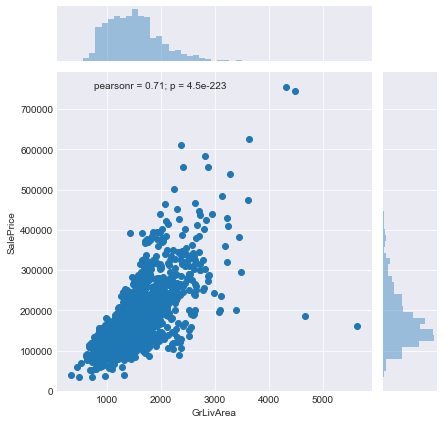

In [143]:
sns.jointplot(data=all_data[all_data['SalePrice'] > 0], x='GrLivArea', y='SalePrice')

In [144]:
all_data[(all_data['SalePrice'] > 0) & (all_data['GrLivArea'] > 4000)]

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,CentralAir,Condition1,Condition2,Electrical,EnclosedPorch,ExterCond,ExterQual,Exterior1st,Exterior2nd,Fence,FireplaceQu,Fireplaces,Foundation,FullBath,Functional,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,GrLivArea,HalfBath,Heating,HeatingQC,HouseStyle,KitchenAbvGr,KitchenQual,LandContour,LandSlope,LotArea,LotConfig,LotFrontage,LotShape,LowQualFinSF,MSSubClass,MSZoning,MasVnrArea,MasVnrType,MiscFeature,MiscVal,MoSold,Neighborhood,OpenPorchSF,OverallCond,OverallQual,PavedDrive,PoolArea,PoolQC,RoofMatl,RoofStyle,SaleCondition,SalePrice,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
523,3138,1538,0,NaN,3,1Fam,TA,Gd,2260.0,0.0,GLQ,Unf,1.0,0.0,Ex,878.0,Y,PosN,PosN,SBrkr,0,TA,Ex,CemntBd,CmentBd,NaN,Gd,1,PConc,3,Typ,884.0,3.0,TA,Fin,TA,BuiltIn,2007.0,4676,1,GasA,Ex,2Story,1,Ex,Bnk,Gtl,40094,Inside,130.0,IR1,0,60,RL,762.0,Stone,NaN,0,10,Edwards,406,5,10,Y,0,NaN,CompShg,Hip,Partial,184750.0,New,0,Pave,11,3138.0,AllPub,208,2007,2008,2007
691,2444,1872,0,NaN,4,1Fam,TA,Gd,1455.0,0.0,GLQ,Unf,0.0,1.0,Ex,989.0,Y,Norm,Norm,SBrkr,0,TA,Ex,HdBoard,HdBoard,NaN,Ex,2,PConc,3,Typ,832.0,3.0,TA,Fin,TA,Attchd,1994.0,4316,1,GasA,Ex,2Story,1,Ex,Lvl,Gtl,21535,Corner,104.0,IR1,0,60,RL,1170.0,BrkFace,NaN,0,1,NoRidge,50,6,10,Y,0,NaN,WdShngl,Gable,Normal,755000.0,WD,0,Pave,10,2444.0,AllPub,382,1994,1995,2007
1182,2411,2065,0,NaN,4,1Fam,TA,Av,2096.0,0.0,GLQ,Unf,1.0,0.0,Ex,300.0,Y,Norm,Norm,SBrkr,0,TA,Gd,Wd Sdng,ImStucc,MnPrv,TA,2,PConc,3,Typ,813.0,3.0,TA,Fin,TA,Attchd,1996.0,4476,1,GasA,Ex,2Story,1,Ex,Lvl,Gtl,15623,Corner,160.0,IR1,0,60,RL,0.0,None,NaN,0,7,NoRidge,78,5,10,Y,555,Ex,CompShg,Hip,Abnorml,745000.0,WD,0,Pave,10,2396.0,AllPub,171,1996,1996,2007
1298,4692,950,0,NaN,3,1Fam,TA,Gd,5644.0,0.0,GLQ,Unf,2.0,0.0,Ex,466.0,Y,Feedr,Norm,SBrkr,0,TA,Ex,Stucco,Stucco,NaN,Gd,3,PConc,2,Typ,1418.0,2.0,TA,Fin,TA,Attchd,2008.0,5642,1,GasA,Ex,2Story,1,Ex,Bnk,Gtl,63887,Corner,313.0,IR3,0,60,RL,796.0,Stone,NaN,0,1,Edwards,292,5,10,Y,480,Gd,ClyTile,Hip,Partial,160000.0,New,0,Pave,12,6110.0,AllPub,214,2008,2008,2008


In [145]:
# Well, these houses can be considered outliers.
all_data.drop(all_data[(all_data['SalePrice'] > 0) & (all_data['GrLivArea'] > 4000)].index, inplace=True)

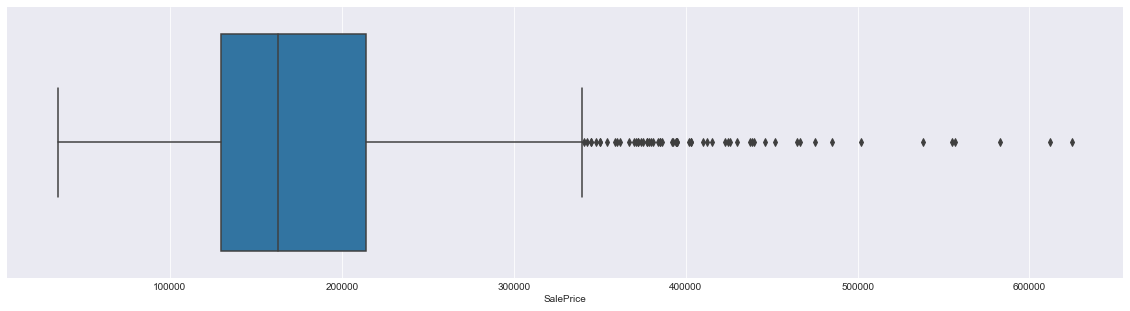

In [146]:
plt.figure(figsize=(20,5))
sns.boxplot(data=all_data[all_data['SalePrice'] > 0], x='SalePrice')

----

## Missing Values

In [147]:
def missing_ratio(df):
    missing = (df.isnull().sum() / df.shape[0]) * 100
    df_nulls = pd.DataFrame(data={'Column': missing.index.values, 'Count': df.isnull().sum().values, 'Ratio': missing.values})
    df_nulls.sort_values(by='Ratio', ascending=False, inplace=True)
    return df_nulls

In [148]:
null_ratios = missing_ratio(all_data)
null_ratios[null_ratios['Count'] > 0]

,Column,Count,Ratio
65,PoolQC,2907,99.725557
56,MiscFeature,2810,96.397942
3,Alley,2717,93.207547
25,Fence,2345,80.445969
26,FireplaceQu,1420,48.713551
49,LotFrontage,486,16.672384
37,GarageYrBlt,159,5.454545
35,GarageQual,159,5.454545
34,GarageFinish,159,5.454545
33,GarageCond,159,5.454545


### LotFrontage

In [149]:
by_neighbor = all_data.groupby(by='Neighborhood', sort=True)
by_neighbor.median()['LotFrontage']

Neighborhood
Blmngtn    43.0
Blueste    24.0
BrDale     21.0
BrkSide    51.0
ClearCr    80.5
CollgCr    70.0
Crawfor    70.0
Edwards    64.5
Gilbert    64.0
IDOTRR     60.0
MeadowV    21.0
Mitchel    74.0
NAmes      73.0
NPkVill    24.0
NWAmes     80.0
NoRidge    88.5
NridgHt    92.0
OldTown    60.0
SWISU      60.0
Sawyer     72.0
SawyerW    67.0
Somerst    72.5
StoneBr    60.0
Timber     82.0
Veenker    80.0
Name: LotFrontage, dtype: float64

In [150]:
# Replace the NaN's in LotFrontage with the neighborhood's median.
def neighborhood_median(row):
    median = by_neighbor['LotFrontage'].median()[row['Neighborhood']]
    return median

all_data['LotFrontage'] = all_data.apply(lambda row: neighborhood_median(row) if np.isnan(row['LotFrontage']) else row['LotFrontage'], axis=1)

In [151]:
# Numeric features...
all_data.fillna({'GarageArea': 0, 
                 'GarageCars': 0,
                 'TotalBsmtSF': 0,
                 'BsmtFullBath': 0,
                 'BsmtHalfBath': 0,
                 'BsmtFinSF1': 0,
                 'BsmtFinSF2': 0,
                 'BsmtUnfSF': 0,
                 'MasVnrArea': 0, 
                 'MasVnrType': 'None'}, inplace=True)

# Columns that are going to be filled with the mode.
mode_columns = ['Electrical', 'MSZoning', 'Utilities', 'Functional', 'Exterior1st', 'Exterior2nd', 'SaleType', 'KitchenQual']
for col in mode_columns:
    all_data.fillna({col: all_data[col].mode()[0]}, inplace=True)    

# Replace GarageCond, GarageType, GarageFinish, GarageQual and GarageYrBlt "NaN's" with "NA" when GarageArea = 0;
mask = (all_data['GarageArea'] == 0)
all_data.loc[mask, ['GarageCond','GarageType','GarageFinish','GarageQual','GarageYrBlt']] = "NA"

# Replace GarageCond, GarageType, GarageFinish, GarageQual and GarageYrBlt "NaN's" with "None" when GarageArea > 0;
mask = (all_data['GarageArea'] > 0)
all_data.loc[mask, ['GarageCond','GarageType','GarageFinish','GarageQual','GarageYrBlt']] = "None"

# Replace BsmtQual, BsmtCond, BsmtFinType1, BsmtFinType2 and BsmtExposure "NaN's" with "NA" when TotalBsmtSF = 0;
mask = (all_data['TotalBsmtSF'] == 0)
all_data.loc[mask, ['BsmtQual','BsmtCond','BsmtFinType1','BsmtFinType2','BsmtExposure']] = "NA"

# Replace BsmtQual, BsmtCond, BsmtFinType1, BsmtFinType2 and BsmtExposure "NaN's" with "None" when TotalBsmtSF > 0;
mask = (all_data['TotalBsmtSF'] > 0)
all_data.loc[mask, ['BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 'BsmtExposure']] = "None"

`PoolQC`, `MiscFeature`, `Alley`, `Fence` and `FireplaceQu` have too many null values. I'm not inputing these features because an input of more than 50% would distort the feature too much. I also dont think they are so important for the predictions so im just discarding these features

In [152]:
all_data.drop(['PoolQC','MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace=True)

In [153]:
# Checking for remaining NaN's
null_ratios = missing_ratio(all_data)
null_ratios[null_ratios['Count'] > 0]

,Column,Count,Ratio


---

# Exploratory Data Analysis

The objective of this step is to know the data, the relations between the variables and the distributions of the features.

## Numeric Features

### Correlation Matrix

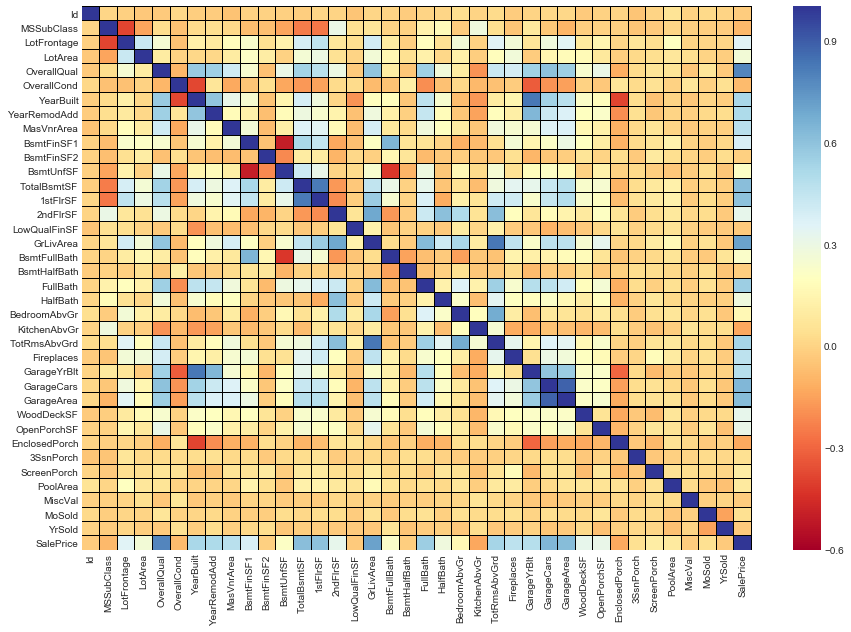

In [154]:
# Plot a heatmap to understand how the features are correlated with the target (SalePrice).
plt.figure(figsize=(15,10))
sns.heatmap(df_train.corr(), cmap='RdYlBu', linewidths=.01, linecolor='black', vmin=-0.6, vmax=1)

- `TotalBsmtSF`, `1stFlrSF`, `GrLivArea`, `GarageCars`, `GarageArea` and `FullBath` are the most correlated features w/ `SalePrice`.
- `TotalBsmtSF` and `1stFlrSF` are strongly correlated.
- `GrLivArea` and `TotRmsAbvGrd` are strongly correlated.
- `GarageCars` and `GarageArea`are strongly correlated.

### LotFrontage

Linear feet of street connected to property.

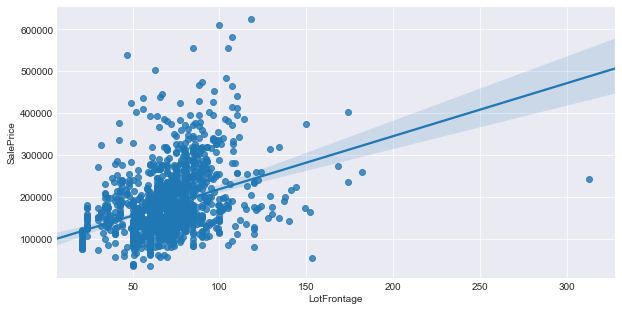

In [155]:
plt.figure(figsize=(10,5))
sns.regplot(data=all_data[all_data['SalePrice'] > 0], x='LotFrontage', y='SalePrice')

In [156]:
all_data[(all_data['SalePrice'] > 0) & (all_data['LotFrontage'] > 300)]

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,CentralAir,Condition1,Condition2,Electrical,EnclosedPorch,ExterCond,ExterQual,Exterior1st,Exterior2nd,Fireplaces,Foundation,FullBath,Functional,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,GrLivArea,HalfBath,Heating,HeatingQC,HouseStyle,KitchenAbvGr,KitchenQual,LandContour,LandSlope,LotArea,LotConfig,LotFrontage,LotShape,LowQualFinSF,MSSubClass,MSZoning,MasVnrArea,MasVnrType,MiscVal,MoSold,Neighborhood,OpenPorchSF,OverallCond,OverallQual,PavedDrive,PoolArea,RoofMatl,RoofStyle,SaleCondition,SalePrice,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
934,2069,0,0,4,1Fam,None,None,425.0,0.0,None,None,1.0,0.0,None,160.0,Y,PosA,Norm,SBrkr,0,TA,TA,Wd Sdng,Wd Sdng,1,CBlock,2,Typ,505.0,2.0,None,None,None,None,None,2069,0,GasA,Ex,1Story,1,Gd,HLS,Mod,27650,Inside,313.0,IR2,0,20,RL,0.0,None,0,11,NAmes,0,7,7,Y,0,Tar&Grv,Flat,Normal,242000.0,WD,0,Pave,9,585.0,AllPub,0,1960,2007,2008


### LotArea

Lot size in square feet.

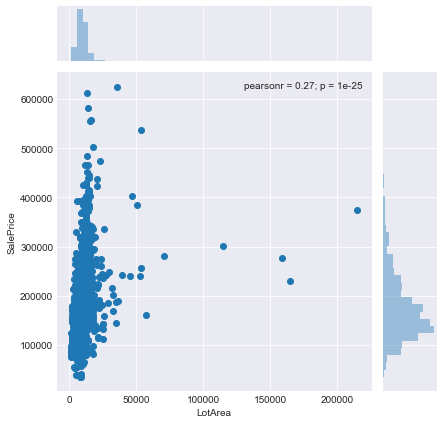

In [157]:
plt.figure(figsize=(10,5))
sns.jointplot(data=all_data[all_data['SalePrice'] > 0], x='LotArea', y='SalePrice')

## Feature Engineering

### TotalSF

In order to remove the multicolinearity between TotalBsmtSF and 1stFlrSF i'm creating a new feature called `TotalSF`, where:<br>
<b>TotalSF = TotalBsmtSF + 1stFlrSF + 2ndFlrSF <br></b>
This will be like my 'main' feature for the house size. <br>
It also replaces <b>GrLivArea</b> because of multicolinearity.

In [158]:
#all_data['TotalSF'] = all_data['1stFlrSF'] + all_data['2ndFlrSF']
#all_data.drop(['TotalBsmtSF','1stFlrSF','2ndFlrSF', 'GrLivArea'], axis=1, inplace=True)

In [159]:
#sns.jointplot(x = all_data[all_data['test'] == False]['TotalSF'], y=df_train['SalePrice'])

### HouseAge

This feature represents the age of the house in the moment of the sale, ie the difference between the year of sale and year of construction.

In [160]:
all_data['HouseAge'] = all_data.apply(lambda x: x['YrSold'] - x['YearBuilt'] if x['YrSold'] >= x['YearBuilt'] else 0, axis=1)
all_data.drop(['YrSold', 'YearBuilt'], axis=1, inplace=True)

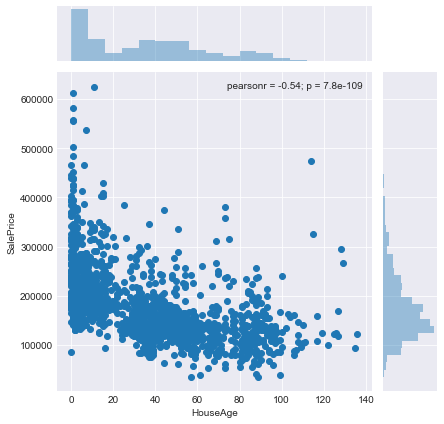

In [161]:
sns.jointplot(data=all_data[all_data['SalePrice'] > 0], x='HouseAge', y='SalePrice')

### HasPool

Even though `PoolArea` isn't highly correlated with saleprice, a pool would certainly increase the price of a house, so I'm creating a flag to indicate if there's a pool or not.

In [162]:
all_data['HasPool'] = all_data['PoolArea'].apply(lambda x: 'Y' if x > 0 else 'N')
all_data.drop('PoolArea', axis=1, inplace=True)

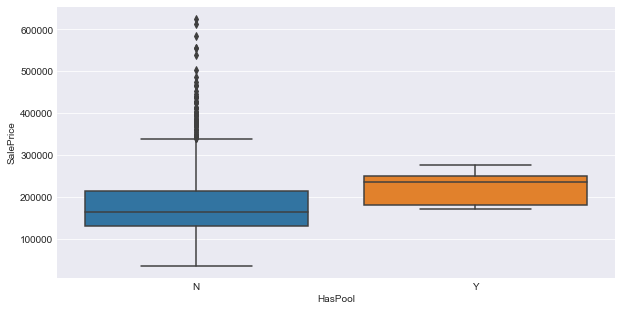

In [163]:
plt.figure(figsize=(10,5))
sns.boxplot(data=all_data[all_data['SalePrice'] > 0], x='HasPool', y='SalePrice')

In [164]:
all_data = pd.get_dummies(all_data, drop_first=True, columns=['HasPool'])

### Bathrooms

This feature represents the number of bathrooms in the house: <br>
<b>Bathrooms = FullBath + HalfBath + BsmtFullBath + BsmtHalfBath </b> <br>

In [165]:
#all_data['Bathrooms'] = all_data['FullBath'] + all_data['HalfBath'] + all_data['BsmtFullBath'] + all_data['BsmtHalfBath']
all_data.drop(['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath'], axis=1, inplace=True)

In [166]:
#plt.figure(figsize=(10,5))
#sns.boxplot(data=all_data[all_data['SalePrice'] > 0], x='Bathrooms', y='SalePrice')

### TotalBsmtSFFin

This feature represents the total finished square feet of basement area.

In [167]:
all_data['TotalBsmtSFFin'] = all_data['TotalBsmtSF'] - all_data['BsmtUnfSF']
all_data['HasBsmt'] = all_data['TotalBsmtSFFin'].apply(lambda x: 'Y' if x > 0 else 'N')
all_data.drop(['TotalBsmtSF', 'BsmtUnfSF', 'TotalBsmtSFFin'], axis=1, inplace=True)

In [168]:
#plt.figure(figsize=(10,5))
#sns.jointplot(data=all_data[all_data['SalePrice'] > 0], x='TotalBsmtSFFin', y='SalePrice')

In [169]:
all_data = pd.get_dummies(all_data, drop_first=True, columns=['HasBsmt'])

### Polynomial Features

I'm also adding some polynomial features to capture non-linear relationships

In [170]:
# Creating the polynomial features...



In [171]:
# Drop the unused features
all_data.drop(['LotFrontage',
               'YearRemodAdd',
               'MasVnrArea',
               'BsmtFinSF1',
               'BsmtFinSF2',
               'LowQualFinSF',
               'BedroomAbvGr',
               'KitchenAbvGr',
               'TotRmsAbvGrd',
               'Fireplaces',
               'GarageArea',
               'WoodDeckSF',
               'OpenPorchSF',
               'EnclosedPorch',
               '3SsnPorch',
               'ScreenPorch',
               'MiscVal',
               'MoSold',
               '1stFlrSF',
               '2ndFlrSF'], axis=1, inplace=True)

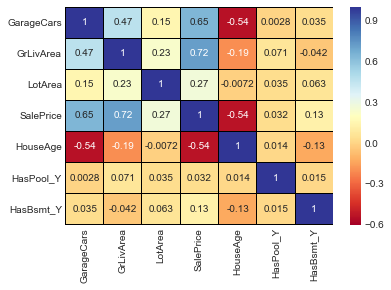

In [172]:
sns.heatmap(data=all_data[all_data['SalePrice'] > 0].corr(), cmap='RdYlBu', 
            linewidths=.01, linecolor='black', vmin=-0.6, vmax=1, annot=True)

---

## Categorical Features

### OverallQual

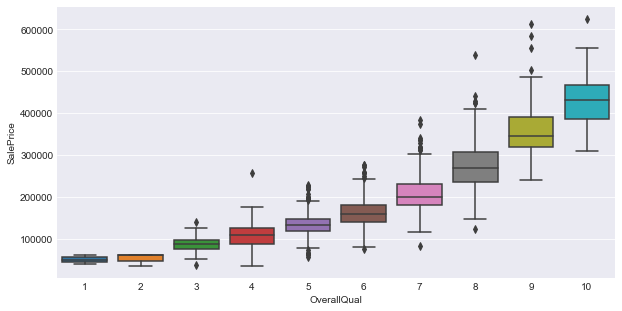

In [173]:
plt.figure(figsize=(10,5))
sns.boxplot(data=all_data[all_data['SalePrice'] > 0], x='OverallQual', y='SalePrice')

### OverallCond

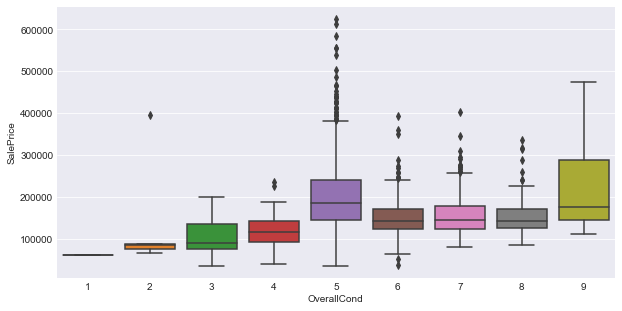

In [174]:
plt.figure(figsize=(10,5))
sns.boxplot(data=all_data[all_data['SalePrice'] > 0], x='OverallCond', y='SalePrice')

### ExterCond

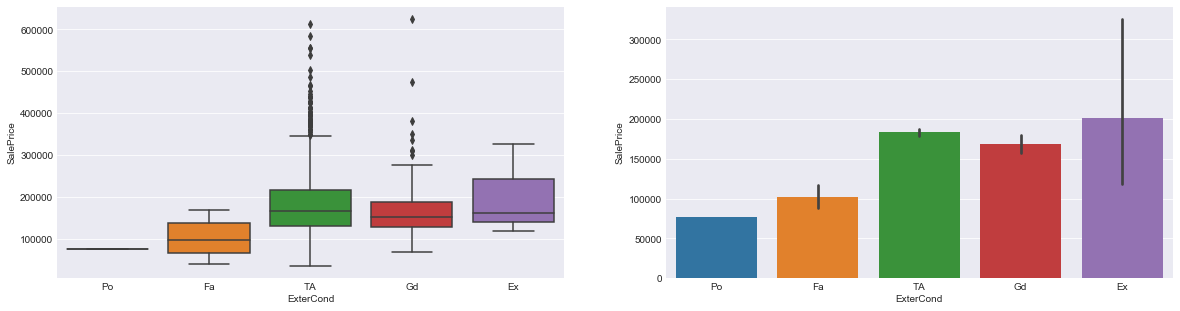

In [175]:
plt.subplots(figsize=(20, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=all_data[all_data['SalePrice'] > 0], x='ExterCond', y='SalePrice', order=['Po','Fa','TA','Gd','Ex'])

plt.subplot(1, 2, 2)
sns.barplot(data=all_data[all_data['SalePrice'] > 0], x='ExterCond', y='SalePrice', order=['Po','Fa','TA','Gd','Ex'])

In [176]:
all_data = pd.get_dummies(all_data, drop_first=True, columns=['ExterCond'])

### KitchenQual

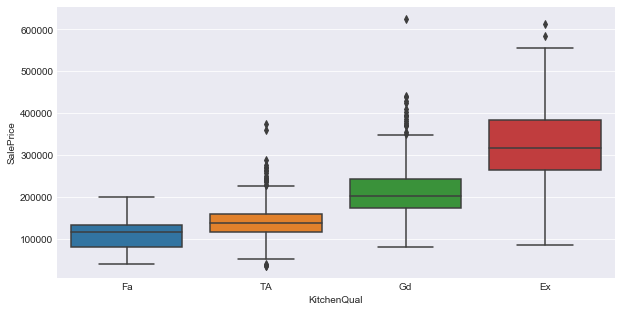

In [177]:
plt.figure(figsize=(10,5))
sns.boxplot(data=all_data[all_data['SalePrice'] > 0], x='KitchenQual', y='SalePrice', order=['Fa','TA','Gd','Ex'])

In [178]:
all_data.replace({'KitchenQual': {'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}}, inplace=True)

### Neighborhood

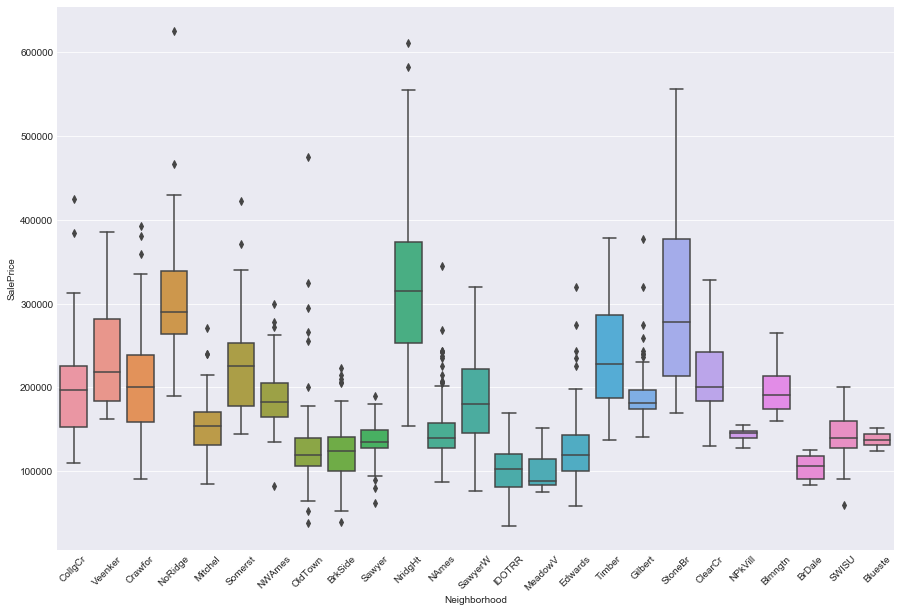

In [179]:
plt.figure(figsize=(15,10))
plt.xticks(rotation=45)
sns.boxplot(data=all_data[all_data['SalePrice'] > 0], x='Neighborhood', y='SalePrice')

In [180]:
all_data = pd.get_dummies(all_data, drop_first=True, columns=['Neighborhood'])

### SaleCondition

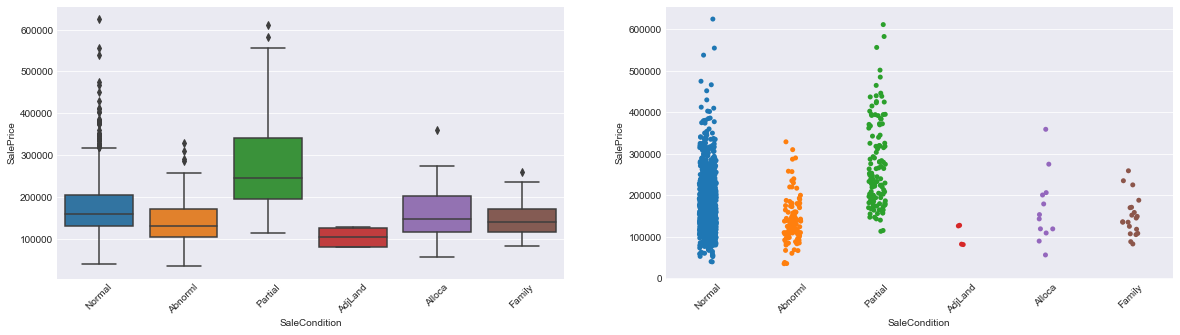

In [181]:
plt.subplots(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.xticks(rotation=45)
sns.boxplot(data=all_data[all_data['SalePrice'] > 0], x='SaleCondition', y='SalePrice')

plt.subplot(1, 2, 2)
plt.xticks(rotation=45)
sns.stripplot(data=all_data[all_data['SalePrice'] > 0], x='SaleCondition', y='SalePrice', jitter=True)

- Since there are only a few observations of AdjLand, Alloca and Family classes, i'm grouping all 3 in one new category called "Other";
- For the remaning three categories, i'm creating dummies because there is no order;

In [182]:
all_data.replace({'SaleCondition': {'AdjLand': 'Other', 
                                    'Alloca': 'Other', 
                                    'Family': 'Other'}}, inplace=True)
all_data = pd.get_dummies(all_data, drop_first=True, columns=['SaleCondition'])

### CentralAir

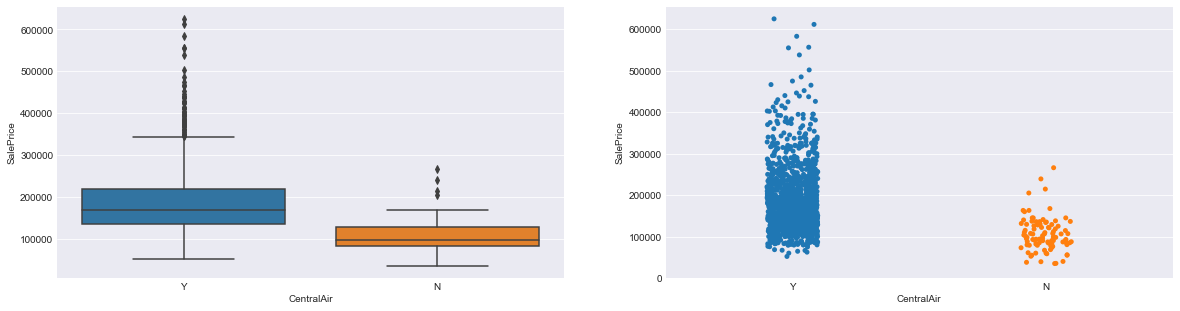

In [183]:
plt.subplots(figsize=(20, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=all_data[all_data['SalePrice'] > 0], x='CentralAir', y='SalePrice')

plt.subplot(1, 2, 2)
sns.stripplot(data=all_data[all_data['SalePrice'] > 0], x='CentralAir', y='SalePrice', jitter=True)

- Most of the houses have a CentralAir system, and it increases the house price;
- Since it's a nominal feature, i'm creating dummies;

In [184]:
all_data = pd.get_dummies(all_data, drop_first=True, columns=['CentralAir'])

### HeatingQC

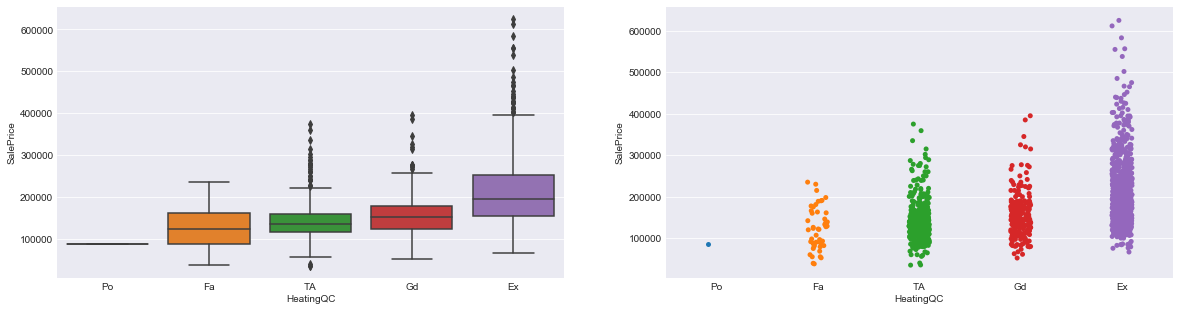

In [185]:
plt.subplots(figsize=(20, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=all_data[all_data['SalePrice'] > 0], x='HeatingQC', y='SalePrice', order=['Po','Fa','TA','Gd','Ex'])

plt.subplot(1, 2, 2)
sns.stripplot(data=all_data[all_data['SalePrice'] > 0], x='HeatingQC', y='SalePrice', jitter=True, order=['Po','Fa','TA','Gd','Ex'])

- HeatingQC has a positive correlation with SalePrice;
- Since it's an ordinal feature, i'm replacing the categories by hand;

In [186]:
all_data.replace({'HeatingQC': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}}, inplace=True)

### MSZoning

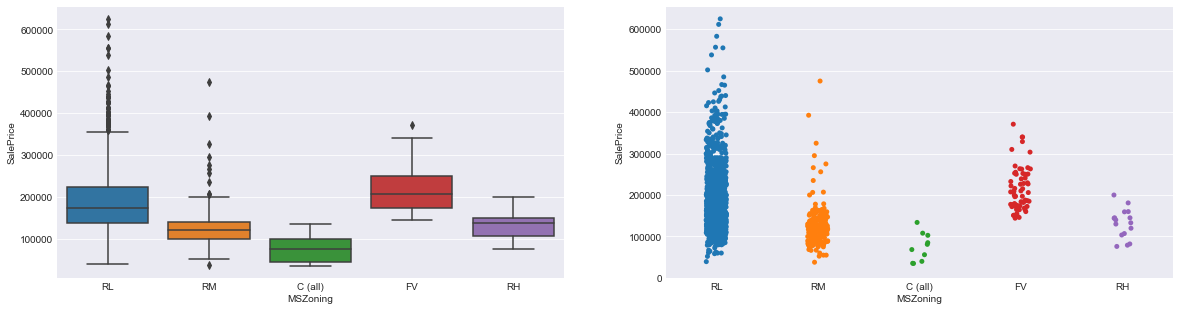

In [187]:
plt.subplots(figsize=(20, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=all_data[all_data['SalePrice'] > 0], x='MSZoning', y='SalePrice')

plt.subplot(1, 2, 2)
sns.stripplot(data=all_data[all_data['SalePrice'] > 0], x='MSZoning', y='SalePrice', jitter=True)

In [188]:
all_data = pd.get_dummies(all_data, drop_first=True, columns=['MSZoning'])

---

In [189]:
all_data.drop(['MSSubClass',
# 'MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'Electrical',
 'Functional',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType'], axis=1, inplace=True)

## Target Variable

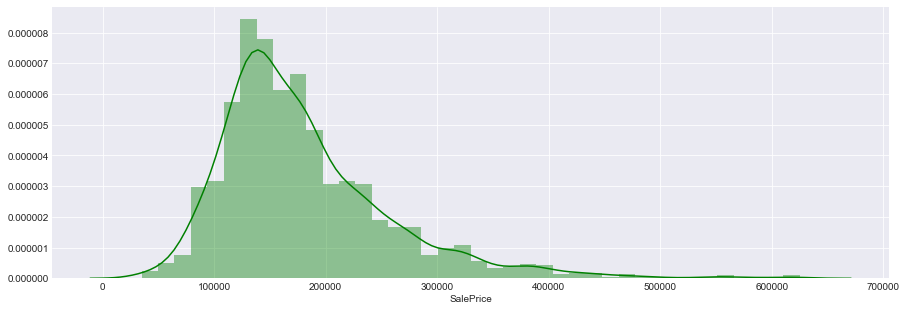

In [190]:
plt.figure(figsize=(15,5))
sns.distplot(all_data[all_data['SalePrice'] > 0]['SalePrice'], color='green')

- The target variable `SalePrice` is not normally distributed. A transformation will be required.

In [191]:
# Applying log transformation.
all_data.loc[all_data['SalePrice'] > 0, 'SalePrice'] = np.log(all_data.loc[all_data['SalePrice'] > 0, 'SalePrice'])

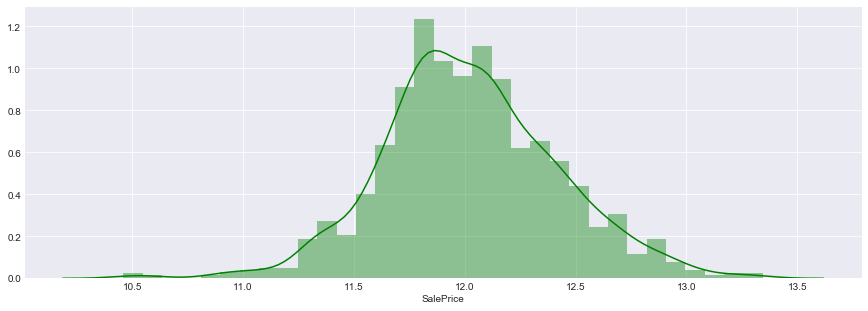

In [192]:
plt.figure(figsize=(15,5))
sns.distplot(all_data[all_data['SalePrice'] > 0]['SalePrice'], color='green')

## Skewed Features

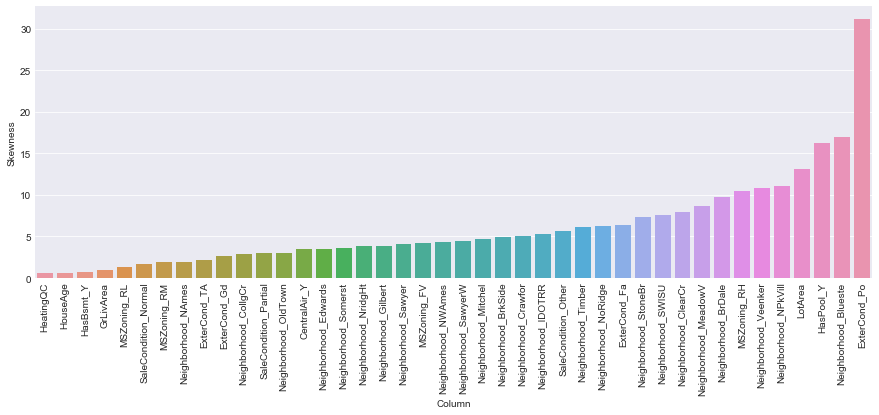

In [193]:
df_skew = pd.DataFrame(columns=['Column', 'Skewness'])
for feature in all_data.select_dtypes(exclude='object').columns:
    df_skew = df_skew.append({'Column': feature , 'Skewness': abs(skew(all_data[feature]))}, ignore_index=True)
df_skew = df_skew[df_skew['Skewness'] >= 0.5]

plt.figure(figsize=(15,5))
plt.xticks(rotation=90)
sns.barplot(data=df_skew.sort_values(by='Skewness'), x='Column', y='Skewness')

In [194]:
for feature in df_skew['Column']:
    all_data[feature] = np.log1p(all_data[feature])

## Model / Validation

### General Definitions

In [195]:
# Cross Validation Strategy...
cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)

# Score to be evaluated
scoring = 'neg_mean_squared_error'

### Train/Test Split

In [196]:
y_train = all_data.loc[all_data['SalePrice'] > 0, 'SalePrice']
X_train = all_data.loc[all_data['SalePrice'] > 0].drop('SalePrice', axis=1)
X_test = all_data.loc[all_data['SalePrice'] == 0].drop('SalePrice', axis=1)

print('Train Set: {}, {}'.format(X_train.shape[0], X_train.shape[1]))
print('Test Set: {}, {}'.format(X_test.shape[0], X_test.shape[1]))

Train Set: 1456, 46
Test Set: 1459, 46


In [197]:
X_train.columns

Index(['GarageCars', 'GrLivArea', 'HeatingQC', 'KitchenQual', 'LotArea',
       'OverallCond', 'OverallQual', 'HouseAge', 'HasPool_Y', 'HasBsmt_Y',
       'ExterCond_Fa', 'ExterCond_Gd', 'ExterCond_Po', 'ExterCond_TA',
       'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide',
       'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor',
       'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_IDOTRR',
       'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes',
       'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU',
       'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst',
       'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker',
       'SaleCondition_Normal', 'SaleCondition_Other', 'SaleCondition_Partial',
       'CentralAir_Y', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL',
       'MSZ

### Standartization

In [198]:
print('Scaling Features...')
#scaler = StandardScaler()
scaler = RobustScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_test[X_test.columns] = scaler.transform(X_test[X_test.columns])
print('Scaling OK')

Scaling Features...
Scaling OK


### Alpha (Regularization) Tuning

In [199]:
# Finding best value of Alpha
df_alphas = pd.DataFrame(columns=['Alpha', 'RMSE'])
alphas = []

for alpha in np.logspace(-10, 1, 300):
    
    list_mse = []
    rmse = 0
    model = Lasso(alpha=alpha)

    for train_index, test_index in cv.split(X_train, y_train):
        X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]

        model.fit(X_train_cv, y_train_cv)
        predictions = model.predict(X_test_cv)
        
        rmse = np.sqrt(mean_squared_error(y_test_cv, predictions))
        list_mse.append(rmse)
                                       
    df_alphas = df_alphas.append({'Alpha': alpha, 'RMSE': np.mean(list_mse)}, ignore_index=True)

df_alphas.sort_values(by='RMSE', inplace=True)
df_alphas.head()

,Alpha,RMSE
152,0.000039,0.123162
153,0.000043,0.123163
149,0.000030,0.123163
151,0.000036,0.123163
150,0.000033,0.123163


In [200]:
my_alpha = 0.00005
model = Lasso(alpha=my_alpha)

### Model Evaluation -  Learning Curves

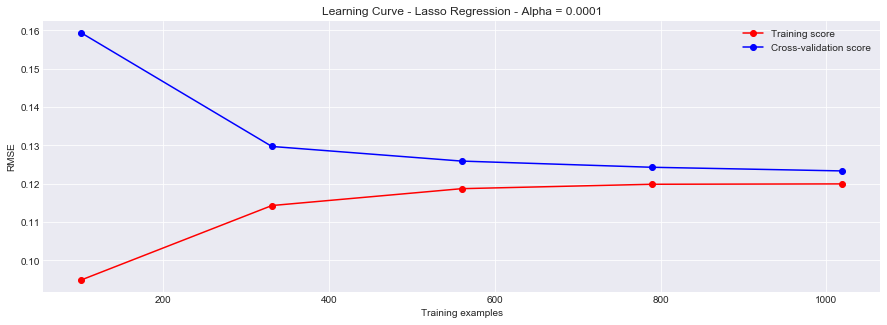

In [201]:
# Define train set sizes
train_sizes = np.linspace(.1, 1.0, 5)

train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=cv, train_sizes=train_sizes, scoring=scoring)
train_rmse = np.sqrt(-np.mean(train_scores, axis=1))
cv_rmse = np.sqrt(-np.mean(test_scores, axis=1))

plt.figure(figsize=(15,5))
plt.title("Learning Curve - Lasso Regression - Alpha = %.4f" % my_alpha)
plt.xlabel("Training examples")
plt.ylabel("RMSE")
plt.plot(train_sizes, train_rmse, 'o-', color="r", label="Training score")
plt.plot(train_sizes, cv_rmse, 'o-', color="b", label="Cross-validation score")

plt.legend(loc="best")
plt.show()

In [203]:
# Best So Far: 0.12316993906326786
rmse = np.mean(np.sqrt(-cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring)))
rmse

0.12316993906326786

In [204]:
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_train, y_train, test_size=0.3, random_state=0)
model.fit(X_train_cv, y_train_cv)
pred = model.predict(X_test_cv)

In [205]:
df_coefs = pd.DataFrame(columns=['Column', 'Coef'])
df_coefs['Column'] = X_test_cv.columns
df_coefs['Coef'] = model.coef_
df_coefs.sort_values(by='Coef', ascending=False)

,Column,Coef
42,MSZoning_FV,0.385134
44,MSZoning_RL,0.363940
43,MSZoning_RH,0.355846
45,MSZoning_RM,0.320547
35,Neighborhood_StoneBr,0.273230
28,Neighborhood_NoRidge,0.192600
1,GrLivArea,0.187329
19,Neighborhood_Crawfor,0.162377
29,Neighborhood_NridgHt,0.161066
8,HasPool_Y,0.144464


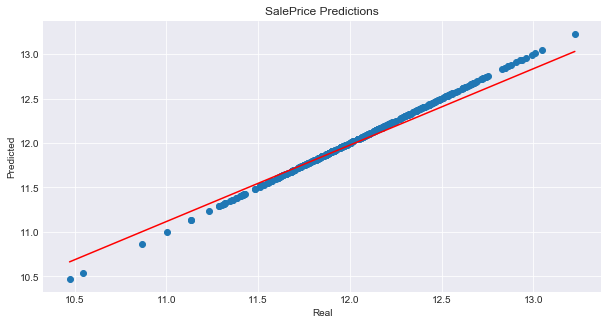

In [206]:
fig,ax = plt.subplots(figsize=(10,5))
ax.scatter(y_test_cv, y_test_cv)
ax.plot([y_test_cv.min(), y_test_cv.max()], [pred.min(), pred.max()], c='r')
ax.set_title('SalePrice Predictions')
ax.set_xlabel('Real')
ax.set_ylabel('Predicted')
fig.show()

In [207]:
check = pd.DataFrame(columns=['real_value', 'prediction', 'real_value_transformed', 'prediction_transformed'])
check['real_value'] = y_test_cv
check['prediction'] = pred
check['real_value_transformed'] = np.exp(check['real_value'])
check['prediction_transformed'] = np.exp(check['prediction'])
check[check['real_value'] < 11.5].loc[[1337, 916, 968, 976, 434]]

,real_value,prediction,real_value_transformed,prediction_transformed
1337,10.868568,10.926539,52500.0,55633.400810
916,10.471950,10.664104,35311.0,42791.914182
968,10.542706,11.081050,37900.0,64929.040072
976,11.356272,11.394412,85500.0,88823.957714
434,11.302204,11.268330,81000.0,78302.149224


In [208]:
df_train.loc[[968, 976]]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
968,969,50,RM,50.0,5925,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1.5Fin,3,6,1910,1950,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,600,600,Grav,Fa,N,SBrkr,600,368,0,968,0,0,1,0,2,1,TA,6,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Y,0,0,0,0,0,0,NaN,GdWo,NaN,0,5,2009,WD,Abnorml,37900
976,977,30,RL,51.0,5900,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,BrkSide,Norm,Norm,1Fam,1Story,4,7,1923,1958,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,440,440,GasA,TA,Y,FuseA,869,0,0,869,0,0,1,0,2,1,Fa,4,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,8,2006,WD,Normal,85500


## Submission

In [210]:
model.fit(X_train, y_train)
sub_pred = model.predict(X_test)

In [211]:
submission['SalePrice'] = np.exp(sub_pred)
submission.to_csv('submission.csv',index=False)
submission.head()

,Id,SalePrice
0,1461,120811.688014
1,1462,164054.703778
2,1463,173769.292499
3,1464,196416.947281
4,1465,217011.527973


In [213]:
%%cmd
@echo off
#kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission.csv -m "27/02/2019 - Teste Com CentralAir"
kaggle competitions submissions -c house-prices-advanced-regression-techniques

Microsoft Windows [versÆo 10.0.15063]
(c) 2017 Microsoft Corporation. Todos os direitos reservados.

c:\Projetos_Python\Kaggle\kaggle-house-prices-iowa>@echo off
#kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission.csv -m "27/02/2019 - Teste Com CentralAir"
kaggle competitions submissions -c house-prices-advanced-regression-techniques
fileName        date                 description                                      status    publicScore  privateScore  
--------------  -------------------  -----------------------------------------------  --------  -----------  ------------  
submission.csv  2019-03-06 14:45:55  27/02/2019 - Teste Com CentralAir                complete  0.13639      None          
submission.csv  2019-02-28 23:04:57  27/02/2019 - Teste Com CentralAir                complete  0.13913      None          
submission.csv  2019-02-28 01:17:16  27/02/2019 - Teste Com CentralAir                complete  0.13977      None          
submiss

'#kaggle' nÆo ‚ reconhecido como um comando interno
ou externo, um programa oper vel ou um arquivo em lotes.
